**BVM Hands-On Tutorial (Part 2/2)**

In this second part of the  tutorial, we will demonstrate how to use PyTorch's autograd engine to register medical images.

Let's again add all imports and mount the Google drive for data storage:

In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import ConstantPad3d as Pad
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from ipywidgets import IntProgress
from IPython.display import display
import time




from google.colab import drive
import tarfile

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
!git clone https://github.com/multimodallearning/bvm_tutorial.git
from bvm_tutorial.utils import loadRegData, MINDSSC3d, img_warp, label_warp,\
jacobian_determinant_3d, overlaySegment_part1

fatal: destination path 'bvm_tutorial' already exists and is not an empty directory.


If run for the first time, you need to extract the data on the Google drive:

In [0]:
tar = tarfile.open(name='/content/drive/My Drive/Task02_Heart.tar', mode='r')
tar.extractall()
tar.close()

Chose two images from the Heart dataset. One will be the *fixed*  image and the other one will be the *moving* image that should be transformed in a way that it resembles the *fixed* image. However, its transformation should be plausible, i.e. especially in the medical case e.g. folding should be prohibited.
In order to achieve this, the following cells will guide you.
First, we load our image data. The label data will later be used to evaluate the transformation - to check if the segmented structures align better after registration.

In [4]:
 with torch.no_grad():

  data_base_path = '/content/Task02_Heart'

  fixed_image_path = data_base_path + '/imagesTr/la_007.nii.gz'
  fixed_label_path = data_base_path + '/labelsTr/la_007.nii.gz'

  moving_image_path = data_base_path + '/imagesTr/la_023.nii.gz'
  moving_label_path = data_base_path + '/labelsTr/la_023.nii.gz'

  fixed_image,\
  fixed_label,\
  moving_image,\
  moving_label = loadRegData(fixed_image_path, fixed_label_path,
                             moving_image_path, moving_label_path)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


As a measure of alignment before the registration, we can compute the dice coefficient of the segmented
structures and also visualize two slices from both image volumes.

Dice init:  tensor(0.4896)


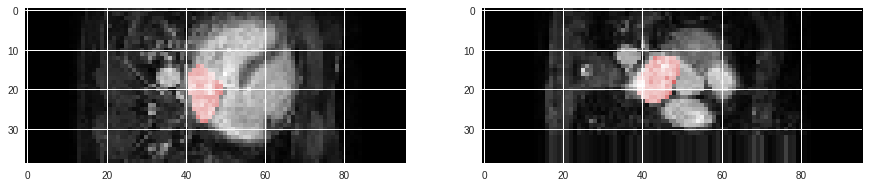

In [16]:
plt_slice = 48

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(overlaySegment_part1(fixed_image[0,0,:,plt_slice,:],fixed_label[0,0,:,plt_slice,:]))
plt.subplot(122)
plt.imshow(overlaySegment_part1(moving_image[0,0,:,plt_slice,:],moving_label[0,0,:,plt_slice,:]))


def dice_val(f_label, m_label):
  numerator = 2.0*torch.sum(f_label.view(-1) * m_label.view(-1))
  denominator = torch.sum(f_label.view(-1)) + torch.sum(m_label.view(-1))
  return numerator / denominator
dice_init = dice_val(fixed_label, moving_label)
print('Dice init: ', dice_init)

Now, we want to register the images.

Given a pair of images $(\mathcal{F}, \mathcal{M})$, where the moving image $\mathcal{M}$ should be aligned with the fixed image $\mathcal{F}$, we formulate this problem as 
\begin{equation}
    argmin_{\varphi} ~ \mathcal{D}(\mathbf{S}_{\mathcal{F}}, \varphi\circ\mathbf{S}_{\mathcal{M}}) + \alpha\mathcal{R}(\varphi)
\end{equation}

i.e. we search the transformation $\varphi$, that best transforms $\mathbf{S}_{\mathcal{M}}$ towards $\mathbf{S}_{\mathcal{F}}$. 

Note that

1.    $\mathbf{S}_{\mathcal{M/F}}$ denote representations of $\mathcal{M/F}$. If $\mathbf{S}$ is the identity, the images are represented by their greyvalues themselves. Here, we will use the *MIND* descriptor as image representation, which would also be capable of handling multi-modal images.
2.  $ \mathcal{D}(\cdot)$ penalizes dissimilarities, e.g. when choosing the *Sum of Squared Differences* (SSD) as measure, we would prefer small differences between at every image position when comparing $\mathbf{S}_{\mathcal{F}}(\mathbf{x})$ and $(\varphi\circ\mathbf{S}_{\mathcal{F}})(\mathbf{x})$.
3.  weighted by a scalar $\alpha$, $\mathcal{R}(\varphi)$ penalizes implausible transformations, i.e. folding or abrupt changes in deformation field values for neighboring positions.

This leaves the following tasks to do:


1.   Compute the *MIND* representations of the fixed and moving images.
2.   Define a similarity measure function.
3.   Define the regularizer as a function.
4.   Optimize the transformation parameters.




1. Compute the *MIND* features.

In [6]:
with torch.no_grad():

  fixed_feat = MINDSSC3d(fixed_image.cuda()).cpu()
  moving_feat = MINDSSC3d(moving_image.cuda()).cpu()
  
  print(fixed_feat.size())
  print(moving_feat.size())

torch.Size([1, 12, 39, 96, 96])
torch.Size([1, 12, 39, 96, 96])


Visualization of a *MIND* slice

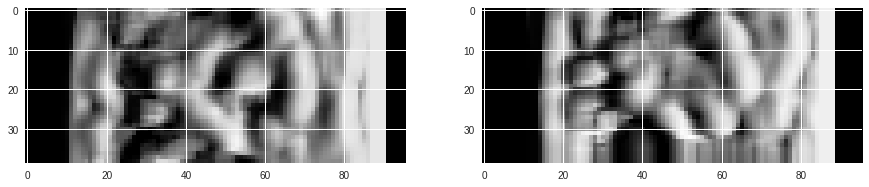

In [7]:
plt_slice = 48
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(fixed_feat[0,0,:,plt_slice,:].detach().cpu().numpy())
plt.subplot(122)
plt.imshow(moving_feat[0,0,:,plt_slice,:].detach().cpu().numpy())

2. Define a loss function: in the *MIND* case its simple, we can use the *Sum of Squared Distances* (SSD)

In [0]:
sim_measure = torch.nn.L1Loss()#MSELoss()

3. Define the regularizer:

In [0]:
# implement beding energy regularisation

# [a,b,c,d,e] 
#     [a,b,c,d,e]  -> x[2:] - x[:-2]: rest: anfang und ende weg! check

def dFdx(field):
    # expects a flowfield : 1xDxHxWx3 -> last dim: x,y,z
    # computes per component derivative (last 3 components in x_dir)
    # and clips it accordingly in the other dimensions, so the size will be diminished by 2 equally
    dx = (field[:,2:,1:-1,1:-1,0] - field[:,:-2,1:-1,1:-1,0]) / 2.0
    dy = (field[:,1:-1,2:,1:-1,0] - field[:,1:-1,:-2,1:-1,0]) / 2.0
    dz = (field[:,1:-1,1:-1,2:,0] - field[:,1:-1,1:-1,:-2,0]) / 2.0
    return torch.stack((dx,dy,dz),dim=4)

def dFdy(field):
    # expects a flowfield : 1xDxHxWx3 -> last dim: x,y,z
    # computes per component derivative (last 3 components in x_dir)
    # and clips it accordingly in the other dimensions, so the size will be diminished by 2 equally
    dx = (field[:,2:,1:-1,1:-1,1] - field[:,:-2,1:-1,1:-1,1]) / 2.0
    dy = (field[:,1:-1,2:,1:-1,1] - field[:,1:-1,:-2,1:-1,1]) / 2.0
    dz = (field[:,1:-1,1:-1,2:,1] - field[:,1:-1,1:-1,:-2,1]) / 2.0
    return torch.stack((dx,dy,dz),dim=4)

def dFdz(field):
    # expects a flowfield : 1xDxHxWx3 -> last dim: x,y,z
    # computes per component derivative (last 3 components in x_dir)
    # and clips it accordingly in the other dimensions, so the size will be diminished by 2 equally
    dx = (field[:,2:,1:-1,1:-1,2] - field[:,:-2,1:-1,1:-1,2]) / 2.0
    dy = (field[:,1:-1,2:,1:-1,2] - field[:,1:-1,:-2,1:-1,2]) / 2.0
    dz = (field[:,1:-1,1:-1,2:,2] - field[:,1:-1,1:-1,:-2,2]) / 2.0
    return torch.stack((dx,dy,dz),dim=4)


class BendingEnergyReg(torch.nn.Module):
    def __init__(self):
        super(BendingEnergyReg, self).__init__()
    
    def forward(self, field):
        # compute dx, dy, dz
        dx = dFdx(field.grid)
        dy = dFdy(field.grid)
        dz = dFdz(field.grid)
        
        # second derivatives & mixed terms
        dxx = dFdx(dx)
        dyy = dFdy(dy)
        dzz = dFdz(dz)
        dxy = dFdy(dx)
        dyz = dFdz(dy)
        dxz = dFdz(dx)
        
        # putting it all together
        penalty = torch.sum(dxx**2 + dyy**2 + dzz**2 + 2.0*(dxy**2 + dyz**2 + dxz**2))
        
        return penalty * (1.0/torch.numel(dxx))

Build the registration optimization process:
- Define the transformation grid as parameters that have to be backpropagated into & updated
- Use a coarse grid & employ B-Spline interpolation methods to upsample it again
- For several iterations, update the parameter tensor with the Adam optimizer

In [0]:
# define a torch.nn.Module that contains the updatable parameters
class displacement_grid(nn.Module):
  def __init__(self, sz0, sz1, sz2):
      super(displacement_grid, self).__init__()
      self.grid = torch.nn.Parameter(torch.zeros(1,sz0,sz1,sz2,3))

  def forward(self, x):
     return self.grid

IntProgress(value=0, max=250)

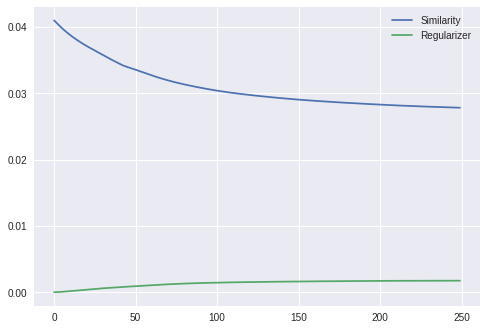

In [11]:
# define the coarse parameter grid -> identity field at first
with torch.no_grad():
  sub_factor = 3 #8
  
  s0 = fixed_image.size(2)
  s1 = fixed_image.size(3)
  s2 = fixed_image.size(4)

  s0_sub = int(s0 / sub_factor)
  s1_sub = int(s1 / sub_factor)
  s2_sub = int(s2 / sub_factor)


  m0, m1, m2 = torch.meshgrid(torch.linspace(-1,1,s0),
                                          torch.linspace(-1,1,s1),
                                          torch.linspace(-1,1,s2))
  
  id_field = torch.stack((m2, m1, m0), dim=3).unsqueeze(0)
  
with torch.enable_grad():
  # this is the parameter tensor
  displ = displacement_grid(s0_sub,s1_sub,s2_sub).cuda()
  
  # set number of registration iterations
  reg_iters = 250
  reg_regul = BendingEnergyReg()
  alpha = 1e1
  
  sim_evo = torch.zeros(reg_iters, requires_grad=False)
  regul_evo = torch.zeros(reg_iters, requires_grad=False)
  
  #displ = displ.cuda()
  #displ = torch.nn.Parameter(displ)
  reg_adam = torch.optim.Adam(displ.parameters(),lr=0.001)#[displ], lr=0.001)
  
  id_field = id_field.cuda().detach()
  fixed_feat = fixed_feat.cuda().detach()
  moving_feat = moving_feat.cuda().detach()
  
  f = IntProgress(min=0, max=reg_iters) # instantiate the bar
  display(f) # display the bar
  
  
  for rdx in range(reg_iters):
    
    reg_adam.zero_grad()
    
    warped_feat = img_warp(moving_feat, id_field, displ.grid)
    
    similarity_val = sim_measure(warped_feat, fixed_feat)
    regularizer_val = alpha*reg_regul(displ)
    optim_val = similarity_val + regularizer_val
    
    optim_val.backward()
    reg_adam.step()
    
    sim_evo[rdx] = similarity_val.item()
    regul_evo[rdx] = regularizer_val.item()
    f.value += 1 # signal to increment the progress bar
    
  plt.figure()
  plt.plot(sim_evo.numpy(),label='Similarity')
  plt.plot(regul_evo.numpy(),label='Regularizer')
  plt.legend()
  
  

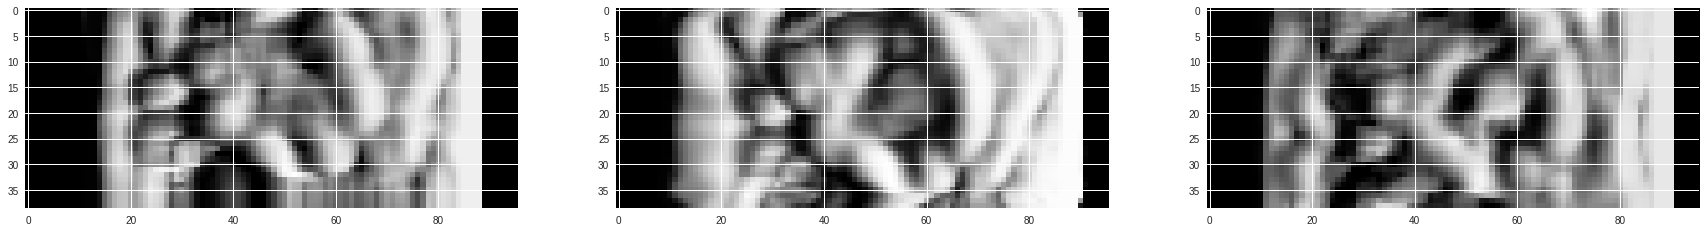

In [12]:

plt.figure(figsize=(30,15))
plt.subplot(131)
plt.imshow(moving_feat[0,0,:,plt_slice,:].detach().cpu())
plt.subplot(132)
plt.imshow(warped_feat[0,0,:,plt_slice,:].detach().cpu())
plt.subplot(133)
plt.imshow(fixed_feat[0,0,:,plt_slice,:].cpu().detach())

check the result (DICE)

Dice init: tensor(0.4896)
Dice reg : tensor(0.7778)


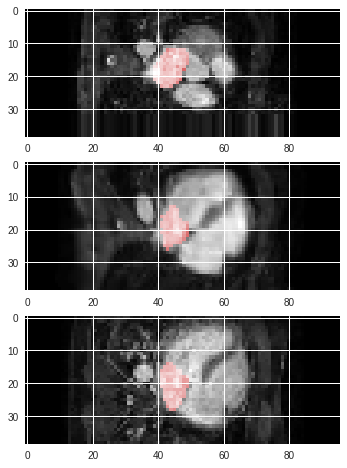

In [18]:
with torch.no_grad():
  
  warped_label = label_warp(moving_label.cuda(), id_field, displ.grid).cpu()
  warped_image = img_warp(moving_image.cuda(), id_field, displ.grid).cpu()
  
  dice_reg = dice_val(fixed_label, warped_label)
  print('Dice init:', dice_init)
  print('Dice reg :', dice_reg)
  
  plt.figure(figsize=(15,8))
  plt.subplot(311)
  plt.imshow(overlaySegment_part1(moving_image[0,0,:,plt_slice,:],moving_label[0,0,:,plt_slice,:]))
  plt.subplot(312)
  plt.imshow(overlaySegment_part1(warped_image[0,0,:,plt_slice,:],warped_label[0,0,:,plt_slice,:]))
  plt.subplot(313)
  plt.imshow(overlaySegment_part1(fixed_image[0,0,:,plt_slice,:],fixed_label[0,0,:,plt_slice,:]))

check the resulting fields plausibility

In [0]:
dense_field = torch.nn.functional.interpolate(displ.grid.permute(0,4,1,2,3),
                                              size=(id_field.size(1), id_field.size(2), id_field.size(3)),
                                              mode='trilinear', align_corners=True).permute(0,2,3,4,1)

jac_det = jacobian_determinant_3d((id_field+dense_field).cpu().permute(0,4,1,2,3))

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

neg_frac = torch.mean((jac_det<0).float())
print('%0.3f'%(jac_det.std()),'%0.3f'%(neg_frac))

0.001 0.000
